In [1]:
import os

#Imports for constructing the Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

#Imports for handling data
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from sklearn.model_selection import train_test_split

#Imports for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import cv2

In [2]:
print(os.listdir("../input/"))

#labels for the training set images
labels = pd.read_csv('../input/train.csv')
#path to training set
train_dir = "../input/train/train"
#path to testing set
test_dir = "../input/test/test"

['test', 'train', 'train.csv', 'sample_submission.csv']


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Device with the hardware where the model will be trained.

(32, 32)


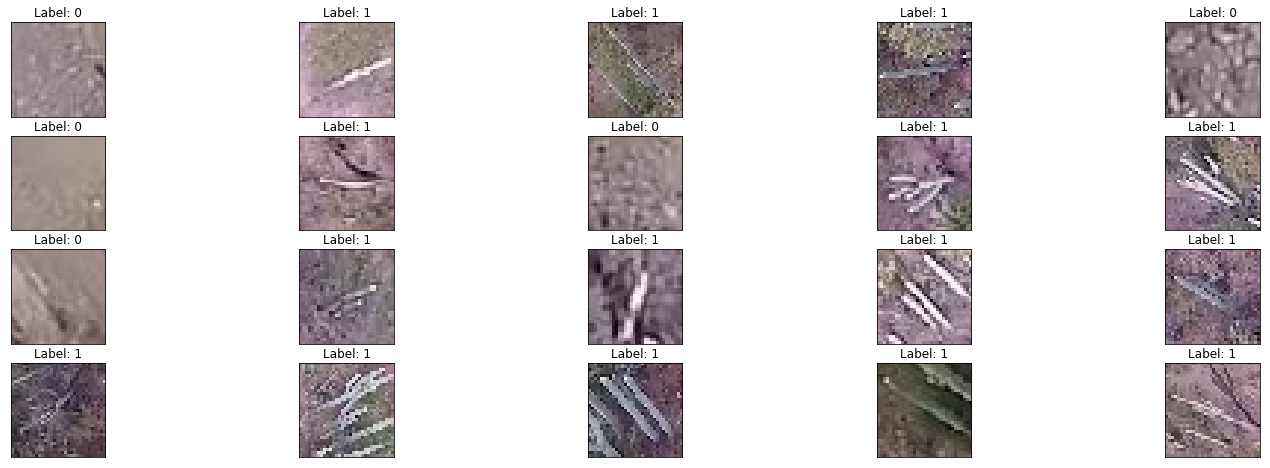

In [4]:
#Copied from "Detecting cactus with kekas" notebook
fig = plt.figure(figsize=(25, 8))
train_imgs = os.listdir("../input/train/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/train/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')
print(im.size)

Images are 32x32
Both vertical and horizontal flips are acceptable, as well as rotation of the images.

In [5]:
labels.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

Only 1/4 of the data has no cactus in it, we can use weights in the loss function in order to punish more the misclassification when there is no cactus.

In [6]:
#From the "SImple CNN on PyTorch for beginers" notebook
class CactusDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [7]:
#ratio of the training set that will be used for validation
val_ratio = 0.15
batch_size =64

# data splitting
train, val = train_test_split(labels, stratify=labels.has_cactus, test_size=val_ratio)
train.shape, val.shape

# Image preprocessing
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(10),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

val_transforms = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Data generators
train_dataset = CactusDataset(df_data=train, data_dir=train_dir, transform=train_transforms)
val_dataset = CactusDataset(df_data=val, data_dir=train_dir, transform=val_transforms)

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [8]:
class CactusNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
          # 3-> number of channels in the input 
          # 32 -> number of kernels used, and the number of channels in the input
          # 3 -> heigth and width of the kernels
          # padding -> adds a padding of 1 in order to not reduce the size of the image
          torch.nn.Conv2d(3, 32, 3, padding=1),    #convolutional layer
          nn.BatchNorm2d(32),                        #normalization layer, normalizes the activations in order to speed up training
          nn.ReLU(),                               #activation layer, uses Rectified Linear Unit
          torch.nn.MaxPool2d(kernel_size=2)        #Pooling layer, chooses max value of a 2x2 square
        ) 
        #data comes out of this layer in the shape 32x16x16
        
        self.layer2 = nn.Sequential(
          torch.nn.Conv2d(32, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2)
        )
        #data comes out of this layer in the shape 64x8x8
        
        self.layer3 = nn.Sequential(
          torch.nn.Conv2d(64, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2)
        )
        #data comes out of this layer in the shape 128x4x4
        
        self.layer4 = nn.Sequential(
          torch.nn.Conv2d(128, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.AvgPool2d(2)
        ) 
        #data comes out of this layer in the shape 128x2x2

        self.fc1 = torch.nn.Linear(2*2*128, 256)
        self.fc2 = torch.nn.Linear(256, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = F.dropout(x, p=0.25)                  #applies a dropout layer, with 0.25 probability of ignoring each element of the input tensor.
        x = self.layer2(x)
        x = F.dropout(x, p=0.25)
        x = self.layer3(x)
        x = F.dropout(x, p=0.25)    
        x = self.layer4(x)
        x = F.dropout(x, p=0.25)  
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25)
        out = self.fc2(x)
        return out
    

In [9]:
def save_model(model, epochs=0, val_loss=-1):
  '''function to save the state of the model, the state of the optimizer, number of current epochs and validation loss'''
  
  checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 
              'epochs': epochs, 'val_loss': val_loss}
  torch.save(checkpoint,'../checkpoint.pt')
  print("Model Saved")

In [10]:
def load_model(checkpoint):
    '''function to load a model and a optimizer with the respective state dicts,
    returning them and the lowest validation loss associated with them'''
    model = CactusNetwork().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    val_loss = checkpoint['val_loss']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer, val_loss

In [11]:

try:                   #if there is a file with a checkpoint of trainning load it and use its data

    #load te checkpoint from the file located in the workspace
    checkpoint = torch.load('../checkpoint.pt')
    print("Loading file")
    model, optimizer, val_loss = load_model(checkpoint)
    
    # track change in validation loss
    valid_loss_min = val_loss
    
    
except FileNotFoundError:   #if there is no file with a checkpoint of trainning, start fresh
    print("Starting fresh")
    
    #instatiate the model
    model = CactusNetwork().to(device)

    #define the optimizer as Adam, give him the model's parameters and define the learning rate as 0.001
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # track change in validation loss
    valid_loss_min = np.Inf
    

#define the weights to be used in the various classes
class_weights = torch.FloatTensor([1,0.5]).cuda()
#define the loss as Cross Entropy Loss
criterion = nn.CrossEntropyLoss(class_weights)

#schedule the lr to decrease by half after every 3 epochs without improvement
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True, min_lr=0.00001)

Starting fresh


In [12]:
# number of epochs to train the model
n_epochs = 60

# number of epochs without improvement that triggers an early stop in trainning
early_stop = 12
es_counter = 0


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy=0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_number, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        # move tensors to GPU if CUDA is available
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #give feedback on current batch of the epoch
        #if batch_number%50 == 0:
            #print("batch number: {}".format(batch_number))
            
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        # move tensors to GPU if CUDA is available
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        _,pred=torch.max(output,1)
        accuracy += torch.sum(pred==target.data)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    accuracy = accuracy.double()/len(val_loader.dataset)
    
    # confirm if the validation loss is decreasing in order to reduce lr
    scheduler.step(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tAccuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,accuracy))
    
    # save model if validation loss has decreased, if not increase early stop counter 
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss))
        save_model(model, epoch, valid_loss)
        valid_loss_min = valid_loss
        es_counter = 0
    else:
        es_counter+=1
    
    #if certain number of epochs have passed without improvement stop the trainning
    if es_counter >= early_stop:
        print("\n\nEarly stop, no improvements in {} epochs".format(early_stop))
        break

Epoch: 1 	Training Loss: 0.156921 	Validation Loss: 0.093590	Accuracy: 0.966095
Validation loss decreased (inf --> 0.093590).  Saving model ...
Model Saved
Epoch: 2 	Training Loss: 0.079605 	Validation Loss: 0.070895	Accuracy: 0.978667
Validation loss decreased (0.093590 --> 0.070895).  Saving model ...
Model Saved
Epoch: 3 	Training Loss: 0.065459 	Validation Loss: 0.046884	Accuracy: 0.983619
Validation loss decreased (0.070895 --> 0.046884).  Saving model ...
Model Saved
Epoch: 4 	Training Loss: 0.056248 	Validation Loss: 0.049721	Accuracy: 0.979810
Epoch: 5 	Training Loss: 0.051004 	Validation Loss: 0.044098	Accuracy: 0.985905
Validation loss decreased (0.046884 --> 0.044098).  Saving model ...
Model Saved
Epoch: 6 	Training Loss: 0.048474 	Validation Loss: 0.044416	Accuracy: 0.984000
Epoch: 7 	Training Loss: 0.041653 	Validation Loss: 0.044986	Accuracy: 0.984381
Epoch: 8 	Training Loss: 0.038268 	Validation Loss: 0.031575	Accuracy: 0.989714
Validation loss decreased (0.044098 --> 0

In [13]:
sub = pd.read_csv('../input/sample_submission.csv')

dataset_test = CactusDataset(df_data=sub, data_dir=test_dir, transform=val_transforms)
test_loader = DataLoader(dataset = dataset_test, batch_size=32, shuffle=False, num_workers=0)

In [14]:
model.eval()

preds = []
for batch_number, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

sub['has_cactus'] = preds
sub.to_csv('sub.csv', index=False)